# Simple permeation simulation

In this task, we'll go through the basics of FESTIM and run a simple permeation simulation on a 1D domain.

In [1]:
import festim as F

The first step is to create a model using a `Simulation` object.

In [2]:
my_model = F.HydrogenTransportProblem()

H = F.Species("H")
my_model.species = [H]

We'll consider a 3 mm-thick material and a regular mesh (1000 cells)

In [3]:
import numpy as np

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 3e-4, num=1001))

`Material` objects hold the materials properties like diffusivity and solubility.

Here we only need the diffusivity defined as an Arrhenius law: $D = D_0 \exp{(-E_D/k_B T)}$ where $k_B$ is the Boltzmann constant in eV/K and $T$ is the temperature in K. From this, the pre-exponential coefficient, $D_0$ in units m<sup>2</sup>/s, and the diffusion actiavtion energy, $E_D$ in units eV are needed.`

In [4]:
material = F.Material(D_0=1.9e-7, E_D=0.2)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=(0, 3e-4), material=material)
left_boundary = F.SurfaceSubdomain1D(id=1, x=0)
right_boundary = F.SurfaceSubdomain1D(id=2, x=3e-4)

my_model.subdomains = [volume_subdomain, left_boundary, right_boundary]

The temperature is set at 500 K

In [5]:
my_model.temperature = 500

FESTIM has a `SievertsBC` class representing Sievert's law of solubility: $c = S \ \sqrt{P}$ at metal surfaces.

> Note:
> 
> A similar class exists for non-metallic materials behaving according to Henry's law: `HenrysBC`

We'll use this boundary condition on the left surface (`id=1`) and will assume a zero concentration on the right side (`id=2`).

In [6]:
P_up = 100  # Pa

my_model.boundary_conditions = [
    F.SievertsBC(subdomain=left_boundary, S_0=4.02e21, E_S=1.04, pressure=P_up, species=H),
    F.FixedConcentrationBC(subdomain=right_boundary, value=0, species=H),
]

With `Settings` we set the main solver parameters.

In [7]:
my_model.settings = F.Settings(atol=1e-2, rtol=1e-10, final_time=100)  # s

Let's choose a stepsize small enough to have good temporal resolution:

In [8]:
my_model.settings.stepsize = F.Stepsize(1 / 20)

For this permeation experiment, we are only interested in the hydrogen flux on the right side:

In [9]:
permeation_flux = F.SurfaceFlux(field=H, surface=right_boundary)

my_model.exports = [permeation_flux]

In [10]:
my_model.initialise()

my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/100 [00:00<?, ?it/s]

Solving HydrogenTransportProblem: 100%|██████████| 100/100 [00:13<00:00, 7.28it/s] 


This problem can be solved analytically. The solution for the downstream flux is:

$$\mathrm{downstream \ flux} = \frac{P_\mathrm{up} \Phi}{L} \left(1 + 2 \sum_{n=1}^{\infty} \left(-1\right)^{n} \exp{(- \frac{\pi^{2} D n^{2} t}{L^{2}})}\right) $$

In [11]:
def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum(
        (-1) ** n_array * np.exp(-((np.pi * n_array) ** 2) * D / L**2 * t), axis=0
    )
    return P_up**0.5 * permeability / L * (2 * summation + 1)

We can compare the computed downstream flux to the analytical solution:

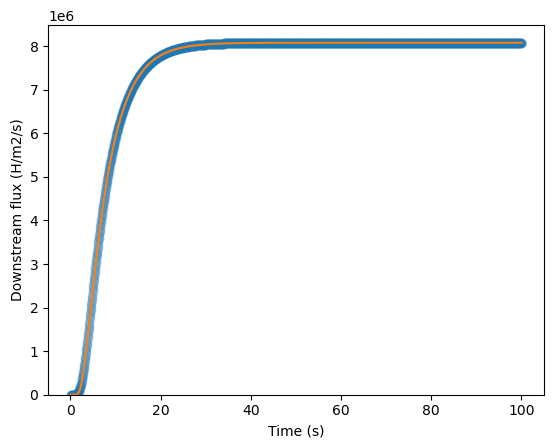

In [12]:
times = permeation_flux.t

D = 1.9e-7 * np.exp(-0.2 / F.k_B / 500)
S = 4.02e21 * np.exp(-1.04 / F.k_B / 500)

import matplotlib.pyplot as plt

plt.scatter(times, np.abs(permeation_flux.data), alpha=0.2, label="computed")
plt.plot(
    times,
    downstream_flux(times, P_up, permeability=D * S, L=3e-4, D=D),
    color="tab:orange",
    label="analytical",
)
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.show()

Phew! We have a good agreement between our model and the analytical solution!

To reproduce simple permeation experiments, the analytical solution is obviously enough.
However, for more complex scenarios (transients, trapping regimes,..) a numerical model provides more flexibility.